# Extracting data and features from seismic data

This tutorial involves extracting data and feature from the data by querying data from the AWS SCEDC bucket

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from time import time
import os
import obspy
from scipy.fftpack import fft, fftfreq, next_fast_len
from obspy.clients.fdsn import Client
# The S3 stuff
import boto3
from botocore import UNSIGNED
from botocore.config import Config

Configure clients to query from webservices and from S3

In [2]:
# FDSN - webservice client
client = Client("SCEDC")

# S3 - SCEDC data bucket
BUCKET_NAME = 'scedc-pds'
s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))

# where to put the data & outputs
os.makedirs('./data' , exist_ok=True)
os.makedirs('./output' , exist_ok=True)

Configure the data query below

In [4]:
net = "CI"
sta = "RIO"
chan = "HHZ"
loc = "*"
year = 2022
mt = 5
day = 9

t0 = datetime.datetime( year , mt , day)     # date time object
doy = int(t0.strftime("%j"))                  # calculate the day of year
tt0 = obspy.UTCDateTime( year , mt ,day)     # Obspy datetime object

# define the file name accordint
file = net+sta+'__'+chan+'___'+str(year)+str(doy).zfill(3)+'.ms'

fmin = 0.1  # mininmum frequenc of the bandpass
fmax = 10   # maximum frequency band

# get data from seb services

Test query data from SCEDC webservices. 

In [38]:

t0 = time()
st1=client.get_waveforms(network = net ,station=sta ,location=loc ,channel=chan ,\
                       starttime=tt0 ,endtime=tt0+86400)
st1.write(file[:-1]+"seed",fmt="mseed")     # this step is not necessary for the analysis but necessary to compare with the download time with S3
t1=time()
print(f"Download time webservices takes {(t1-t0)}  s")

Download time webservices 1.8870368003845215  s


Test query data from S3 bucket. We need to know the file structure of the SCEDC bucket

In [17]:
!aws s3 ls --no-sign-request s3://scedc-pds/

                           PRE FDSNstationXML/
                           PRE Ridgecrest_DAS/
                           PRE continuous_waveforms/
                           PRE earthquake_catalogs/
                           PRE event_phases/
                           PRE event_waveforms/
                           PRE indexmap/
2019-12-18 09:50:20       2041 README


In [18]:
!aws s3 ls --no-sign-request s3://scedc-pds/continuous_waveforms/

                           PRE 1999/
                           PRE 2000/
                           PRE 2001/
                           PRE 2002/
                           PRE 2003/
                           PRE 2004/
                           PRE 2005/
                           PRE 2006/
                           PRE 2007/
                           PRE 2008/
                           PRE 2009/
                           PRE 2010/
                           PRE 2011/
                           PRE 2012/
                           PRE 2013/
                           PRE 2014/
                           PRE 2015/
                           PRE 2016/
                           PRE 2017/
                           PRE 2018/
                           PRE 2019/
                           PRE 2020/
                           PRE 2021/
                           PRE 2022/
                           PRE 2023/
                           PRE index/


In [31]:

# Key defined by SCEDC bucket
KEY = 'continuous_waveforms/'+str(year)+'/'+str(year)+'_'+str(doy).zfill(3)+'/'+file


# download data
t0 = time()
s3.Bucket(BUCKET_NAME).download_file(KEY, './data/' + file)
t1 = time()
print(f"Download time from S3 takes {(t1-t0)} s")
# this would be better if could stream in memory and save into disk

Download time from S3  0.34758901596069336 s


**Repeat the download cells and compare the download times** from webservices vs S3. As you repeat, you notice that the download time is not exactly the same, this depends on a dynamic workload of the backend servers. AWS is specialized in data servers and does it well.

You can test the exact same code on your laptop and see how much time varies now that you are outside of the AWS region.

Below is a silly code to emulate a feature serial extraction workflow.

18076.57017390274 1652130135.478393
2.1815046296296297


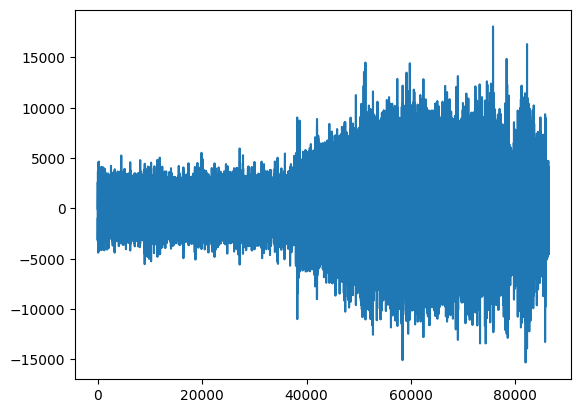

In [39]:
# Feature selection
t0=time()
st = obspy.read('./data/' + file)
t1=time()
print(f"reading time from local storage takes  {(t1-t0)} s")
st.filter('bandpass', freqmin = fmin, freqmax = fmax)
plt.plot(st[0].times(), st[0].data)
plt.savefig('./output/test.png')

# get the maximum value in that frequency band
Amax = np.max(np.abs(st[0].data))
imax = np.argmax(np.abs(st[0].data))
Amaxt = st[0].times(type='timestamp')[imax]  # this is timestamps since POSIX time (197-,1,1).
print( Amax , Amaxt)


# 2. Fourier Transform
npts = st[0].stats.npts
# FFT the signals
# fill up until 2^N value to speed up the FFT
Nfft = next_fast_len(int(st[0].data.shape[0])) # this will be an even number
freqVec = fftfreq(Nfft, d=st[0].stats.delta)[:Nfft//2]
st.taper(max_percentage=0.05)
Zhat = fft(st[0].data , n=Nfft)

imax = np.argmax(np.abs(Zhat[:Nfft//2]/Nfft))
Fmax = imax*st[0].stats.sampling_rate/2/Nfft
print(Fmax)


Save extracted features into a DataFrame and Pandas

In [ ]:

D = {'network':net,'station':sta,'channel':chan,'location':loc,\
     'freqmin':[fmin],'freqmax':[fmax],'date':[Amaxt],'Fmax':[Fmax]}
print(D)
print(Amaxt)


df=pd.DataFrame.from_dict(D)
df.to_csv('./output/features.csv')

To download the data from EC2 to your local, you have two options:

1. From the jupyter notebook webpage, you can right click on the file and download. This is the easiest option when you are doing a manual download of a few files.
2. For larger requests, you have to use ```scp```. For this, open a new terminal and type:
        cd the_directory_where_your_pem_or_ppk_file_is
        scp -i "yourkeycredentials.pem" ec2-user@ec2-ip.amazon.com:/home/ec2-user/seis_cloud/outouts ~/yourchoiceofpath/